In [45]:
    import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
import scipy.stats as sts
pd.set_option('display.max_columns', 50)
from matplotlib.ticker import FormatStrFormatter
sns.set_style(style='whitegrid')
from sklearn.metrics import adjusted_rand_score
import datetime
from sklearn.metrics import silhouette_samples

# Chargement données

#### <font color='purple'> _Fonction compare_stats_</font>

In [3]:
def compare_stats(df, label):
    columns = sorted(list(df[label].unique()))
    index = [('count', 'count')]
    for i in range(len(df.columns)):
        index +=[(df.columns[i], 'mean'), (df.columns[i], 'min'), (df.columns[i], 'max')]
    index = pd.MultiIndex.from_tuples(index)
    compare = pd.DataFrame(index=index, columns=columns, data=0)
    for feature in df.columns:
        for col in compare.columns:
            compare.loc[(feature, 'mean'), col] = df.loc[df[label]==col, feature].mean()
            compare.loc[(feature, 'max'), col] = df.loc[df[label]==col, feature].max()
            compare.loc[(feature, 'min'), col] = df.loc[df[label]==col, feature].min()
            compare.loc[('count', 'count'), col] = df.loc[df[label]==col, feature].count()
    compare = compare.drop([(label, 'mean'), (label, 'min'), (label, 'max')])
    
    return compare   

#### <font color='purple'>_Fonction stability_KMeans_</font>

In [35]:
def stability_KMeans(data, n_clust, n_job):
    rand = [] 
    km_ref = KMeans(n_clusters=n_clust, random_state=0)
    km_ref.fit(data)
    clusters_ref = km_ref.labels_
    random_seeds = random.sample(range(10000000), k=n_job)
    for i in range(n_job):
        km = KMeans(n_clusters= n_clust, random_state=random_seeds[i])
        km.fit(data)
        clusters = km.labels_
        rand += [adjusted_rand_score(clusters_ref, clusters)]
    fig, ax = plt.subplots(figsize=(12, 7))
    colors = sns.color_palette("RdBu", 16)
    x = np.linspace(0, n_job-1, n_job)
    sns.lineplot(x=x, y=rand, color=colors[4])
    if n_job//10==0:
        ax.set_xticks([i for i in range(1, n_job+1)])
    else:
        step = n_job//10
        ax.set_xticks([step*i for i in range(1, n_job//step+1)])
    y0 = np.mean(rand) + (np.max(rand)-np.mean(rand))/10
    ax.text(1, y0,f"Mean = {round(np.mean(rand),4)}", fontsize=14, color=colors[-1], weight='bold')
    sns.lineplot(x=x, y=np.mean(rand), color=colors[-1])
    ax.set_title(f"Adjusted Rand Index pour {n_job} différentes positions \ndes {n_clust} centroïdes de départ", 
                 fontdict={'fontsize':16, 'weight':'bold'})
    ax.set_ylim(0, 1.05)
    fig.savefig(f"stability_{n_clust}_cluster.pdf")

In [5]:
np.linspace(0, 19, 20)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])

In [6]:
data1 = pd.read_csv('data_intermediaire.csv').drop('Unnamed: 0', axis=1)
begining = pd.to_datetime(data1['date_of_purchase'].min()).date()
end = pd.to_datetime(data1['date_of_purchase'].max()).date()

/var/folders/cg/rgv17yks2975h8b2p1c414640000gn/T/ipykernel_1582/2695487401.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('data_intermediaire.csv').drop('Unnamed: 0', axis=1)


In [7]:
data2 = pd.read_csv('data_per_order.csv').drop('Unnamed: 0', axis=1)

In [8]:
data2.head(1)

,week_end,week,morning,afternoon,evening,night,nb_tot_products,freight_value_sum,product_weight_g_mean,clutter_mean,product_name_lenght_mean,product_description_lenght_mean,product_description_lenght_max,product_photos_qty_min,nb_dif_products,nb_dif_sellers,payment_sequential,payment_installments,payment_value,review_score_mean,review_score_min,review_score_max,nb_review_score_per_order,nb_comments_per_order,R,F,M,voucher,customer_unique_id,date_of_purchase
0,2.775558e-17,1.0,0.0,1.0,0.0,0.0,1.0,21.88,8683.0,107136.0,41.0,1141.0,1141.0,1.0,1.0,1.0,1.0,2.0,146.87,4.0,4.0,4.0,1.0,0.0,254.0,1.0,124.99,0.0,861eff4711a542e4b93843c6dd7febb0,2017-05-16


In [9]:
# Sélection des features
data2['date_of_purchase'] = pd.to_datetime(data2['date_of_purchase']).dt.date
data = data2.loc[:, ['customer_unique_id', 'R', 'F', 'M', 'voucher', 'payment_value', 'review_score_mean', 'date_of_purchase']]

In [10]:
data.describe()

,R,F,M,voucher,payment_value,review_score_mean
count,9.944100e+04,99441.0,99441.000000,99441.000000,99441.000000,99441.000000
mean,4.827270e+02,1.0,142.518417,3.815776,160.990790,4.078098
std,1.536706e+02,0.0,222.851762,34.110823,221.950202,1.348155
min,5.684342e-14,1.0,0.000000,0.000000,0.000000,1.000000
25%,3.730000e+02,1.0,46.000000,0.000000,62.010000,4.000000
50%,5.010000e+02,1.0,88.900000,0.000000,105.290000,5.000000
75%,6.070000e+02,1.0,151.900000,0.000000,176.970000,5.000000
max,7.730000e+02,1.0,13440.000000,3184.340000,13664.080000,5.000000


#### <font color='purple'>_Fonction data_date_</font>

In [11]:
# Fonction qui aggrège data par client antérieurement à une certaine date
def data_date(data, col_date, col_agg, date, dict_agg):
    """ 
    Filtre data avec col_date antérieure à date
    Aggrège data par col_agg suivant dict_agg
    Supprime col_agg
    
    date = datetime(year, month, day) 
    (ex : data_datedatetime(2022, 10, 10)) 
    """
    mask = data[col_date] < date
    data_filtered = data[mask]
    data_grouped = data_filtered.groupby(col_agg).agg(dict_agg).reset_index()
    data_final = data_grouped.drop(col_agg, axis=1)
    return data_final

#### <font color='purple'>_Fonction data_date_id_</font>

In [12]:
# Idem mais conserve customer id
def data_date_id(data, col_date, col_agg, date, dict_agg):
    """ 
    Filtre data avec col_date antérieure à date
    Aggrège data par col_agg suivant dict_agg
    
    date = datetime(year, month, day) 
    (ex : data_datedatetime(2022, 10, 10)) 
    """
    mask = data[col_date] < date
    data_filtered = data[mask]
    data_grouped = data_filtered.groupby(col_agg).agg(dict_agg).reset_index()
    return data_grouped

#### <font color='purple'>_Fonction ratio_</font>

In [13]:
def ratio(data, col1, col2):
    """ 
    remplace col1 par le pourcentage que représente col1 par rapport à col2
    """
    data1 = data.copy()
    mask = data1[col2] != 0
    data1.loc[mask, col1] = data1.loc[mask, col1]/data1.loc[mask, col2]*100
    data1 = data1.drop(col2, axis=1)
    return data1

In [14]:
# Dictionnaire pour l'aggrégation
aggregation = {'R':'min', 'F': 'sum', 'M': 'mean', 'voucher':'sum', 'payment_value': 'sum', 
               'review_score_mean':'mean'}

#### <font color='purple'>_Fonction data_per_delay_</font>

In [15]:
# Créer une liste de datasets aggrégés par client et antérieurement à des dates régulièrement réparties
def data_per_delay(data, col_date, col_agg, dict_agg, col1, col2, delay):
    """
    Crée une liste de datasets aggrégés par col_agg suivant dict_agg 
    où les données sont antérieures à des dates régulièrement réparties tous les delay
    """
    
    begin_date = pd.to_datetime(data[col_date].min()).date()
    end_date = pd.to_datetime(data[col_date].max()).date()
    nb_interval = (end_date-begin_date).days//delay+1
    interval = [end_date - i * pd.Timedelta(delay, unit='D') for i in range(nb_interval)]
    data_delay = []
    for i in range(nb_interval):
        data_agg = data_date(data, col_date, col_agg, interval[i], dict_agg)
        data_modif = ratio(data_agg, col1, col2,)
        data_delay += [data_modif]
    return data_delay 

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#### <font color='purple'>_Fonction clusters_</font>

In [17]:
def clusters(X):
    """
    Récupère les labels des clusters par individu
    """
    X_clust = pd.DataFrame(X)
    X_clust['cluster'] = X_clust.idxmin(axis=1)
    return X_clust['cluster']

#### <font color='purple'>_Fonction adjusted_rand_</font>

In [49]:
# Calcul des adjusted rand index entre les clusters entrainés sur le dataset ou les clusters entrainés sur le dataset antérieur d'un certain delay
def adjusted_rand(data, col_date, col_agg, dict_agg, col1, col2, delay, n_clust):
    """
    Calcule les adjusted rand score entre :
        - clustering entrainé à la date t et appliqué aux données à la date t + delay
        - clustering entrainé à la date t + delay et appliqué aux données à la date t + delay
    """
    end_date = pd.to_datetime(data[col_date].max()).date()
    data_delay = data_per_delay(data, col_date, col_agg, dict_agg, col1, col2, delay)
    rand = []
    x = []
    for i in range(len(data_delay)-1):
        if len(data_delay[i+1])>10 and len(data_delay[i])>10:
            km1 = KMeans(n_clusters= n_clust, random_state=42)
            scl = StandardScaler().fit(data_delay[i+1])
            X1_scaled = scl.transform(data_delay[i+1])
            km1.fit(X1_scaled)
            X0_scaled = scl.transform(data_delay[i])
            km0 = KMeans(n_clusters= n_clust, random_state=42)
            X0_model0 = km0.fit_transform(X0_scaled)
            clusters0_model0 = clusters(X0_model0)
            X0_model1 = km1.transform(X0_scaled)
            clusters0_model1 = clusters(X0_model1)
            rand += [adjusted_rand_score(clusters0_model1, clusters0_model0)]
            x += [end_date - i * pd.Timedelta(delay, unit='D')]
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(ax=ax, x=x, y=rand)
    ax.set_ylim(0, 1.05)
    ax.set_title(f"Adjusted Rand Index - Mise à jour tous les {delay} jours", 
                 fontdict={'fontsize':16, 'weight':'bold'})
    fig.savefig(f"RandScore_{delay}_jours.pdf")

#### <font color='purple'>_Fonction silhouette_evolve_</font>

In [60]:
def silhouette_evolve(data, col_date, col_agg, dict_agg, col1, col2, delay, n_clust, sample_size):
    """
    Calcule les silhouette scores calculés pour 
    le clustering entrainé à la date t et appliqué aux données à la date t + delay
    """
    end_date = pd.to_datetime(data[col_date].max()).date()
    data_delay = data_per_delay(data, col_date, col_agg, dict_agg, col1, col2, delay)
    silhouette = []
    x = []
    for i in range(len(data_delay)-1):
        if len(data_delay[i+1])>10 and len(data_delay[i])>10:
            km1 = KMeans(n_clusters= n_clust, random_state=42)
            scl = StandardScaler().fit(data_delay[i+1])
            X1_scaled = scl.transform(data_delay[i+1])
            km1.fit(X1_scaled)
            X0_scaled = scl.transform(data_delay[i])
            km0 = KMeans(n_clusters= n_clust, random_state=42)
            X0_model0 = km0.fit_transform(X0_scaled)
            clusters0_model0 = clusters(X0_model0)
            X0_model1 = km1.transform(X0_scaled)
            clusters0_model1 = clusters(X0_model1)
            if len(X0_model1)>sample_size:
                data_sample = pd.DataFrame(X0_model1).sample(n=sample_size, replace=False)
                index = data_sample.index
                silhouette += [silhouette_samples(data_sample, clusters0_model1[index]).mean()]
                x += [end_date - i * pd.Timedelta(delay, unit='D')]
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(ax=ax, x=x, y=silhouette)
    ax.set_ylim(0, 0.6)
    ax.set_title(f"Silhouette Score - Mise à jour tous les {delay} jours", 
                 fontdict={'fontsize':16, 'weight':'bold'})
    fig.savefig(f"Silhouette_{delay}_jours.pdf")

# Clustering avec 6 clusters

In [20]:
data_end1 = data_date(data, 'date_of_purchase', 'customer_unique_id', end, aggregation)
data_end = ratio(data_end1, 'voucher', 'payment_value')
data_end.describe()

,R,F,M,voucher,review_score_mean
count,9.609500e+04,96095.000000,96095.000000,96095.000000,96095.000000
mean,4.821652e+02,1.034809,142.808817,3.019444,4.076417
std,1.539046e+02,0.214385,222.756580,15.984138,1.343360
min,5.684342e-14,1.000000,0.000000,0.000000,1.000000
25%,3.720000e+02,1.000000,47.000000,0.000000,4.000000
50%,5.010000e+02,1.000000,89.000000,0.000000,5.000000
75%,6.070000e+02,1.000000,152.000000,0.000000,5.000000
max,7.550000e+02,17.000000,13440.000000,100.000000,5.000000


In [21]:
X_scaled0 = StandardScaler().fit_transform(data_end)

In [22]:
# Nombre de clusters souhaités
n_clust = 6
km0 = KMeans(n_clusters= n_clust, random_state=0)
km0.fit(X_scaled0)

# Récupération des clusters attribués à chaque individu
clusters0 = km0.labels_

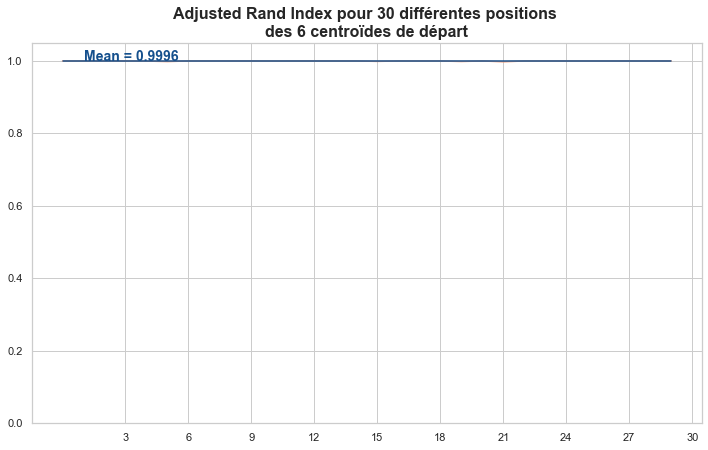

In [30]:
stability_KMeans(X_scaled0, 6, 30)

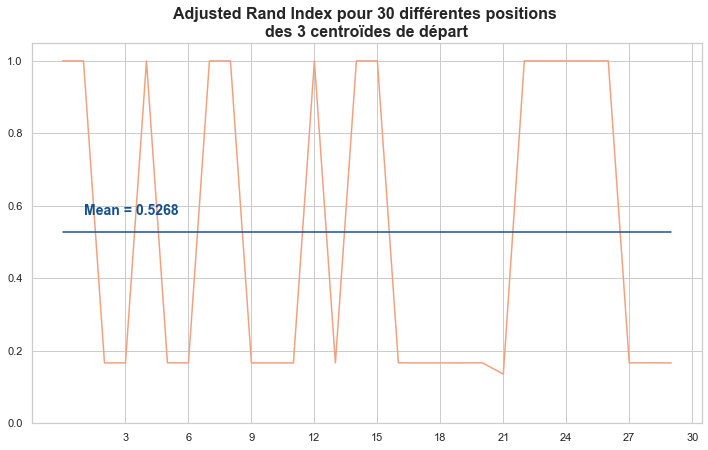

In [37]:
stability_KMeans(X_scaled0, 3, 30)

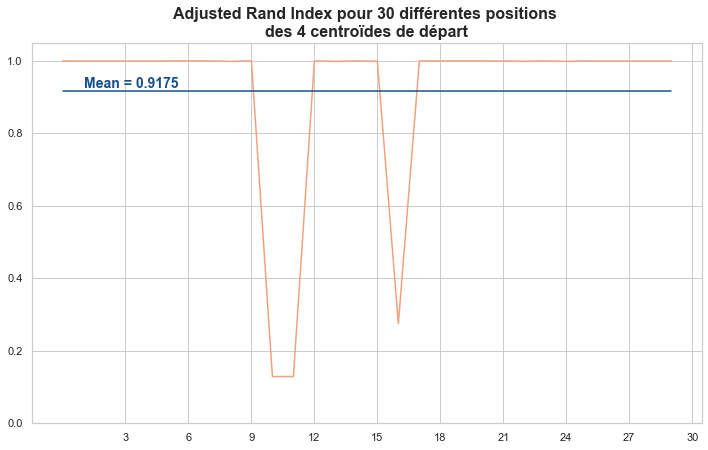

In [36]:
stability_KMeans(X_scaled0, 4, 30)

In [132]:
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_scaled0, clusters0)
silhouette

0.41864989691181853

In [185]:
km0.inertia_

138400.1786985195

In [192]:
X_transformed = pd.DataFrame(km0.transform(X_scaled0))
X_transformed['clusters']=clusters0

## Boxplot par features

In [31]:
data_stat0 = data_end.copy()
data_stat0['label'] = clusters0

In [32]:
def effectif_clusters(data, col_label):
    effectifs = pd.DataFrame(data[col_label].value_counts()).reset_index()
    effectifs = effectifs.rename(columns={'index': 'label', 'label': 'count'})
    effectifs['percent'] = effectifs['count'] / effectifs['count'].sum()*100
    effectifs['percent'] = effectifs['percent'].apply(lambda x: round(x, 0))
    return effectifs
effectif_clusters(data_stat0, 'label')

,label,count,percent
0,3,40952,43.0
1,0,30755,32.0
2,2,16508,17.0
3,4,2969,3.0
4,1,2928,3.0
5,5,1983,2.0


<AxesSubplot:xlabel='label', ylabel='review_score_mean'>

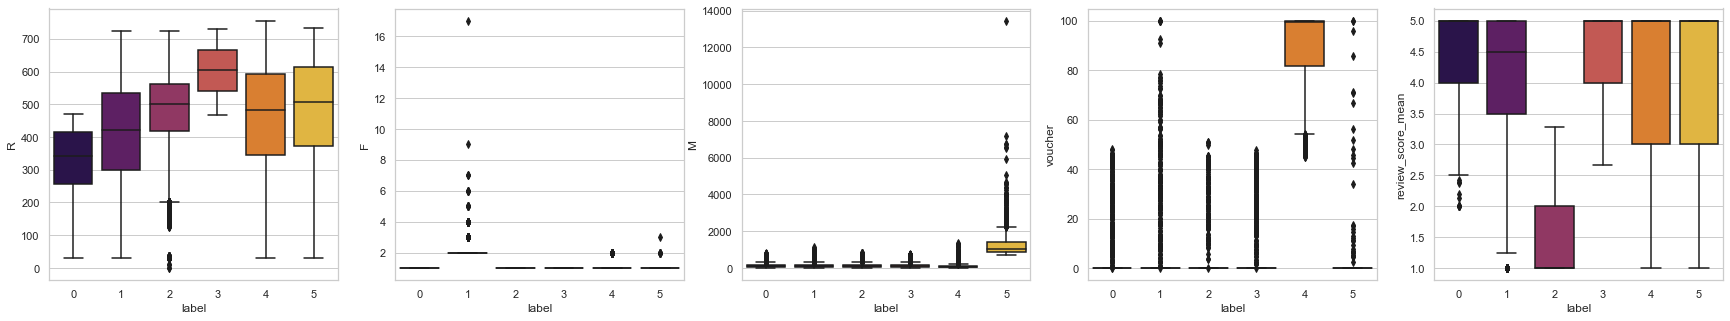

In [33]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
sns.boxplot(ax= ax[0], data=data_stat0, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat0, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat0, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat0, x='label', y='voucher', palette='inferno')
sns.boxplot(ax= ax[4], data=data_stat0, x='label', y='review_score_mean', palette='inferno')

## Boxplot par cluster

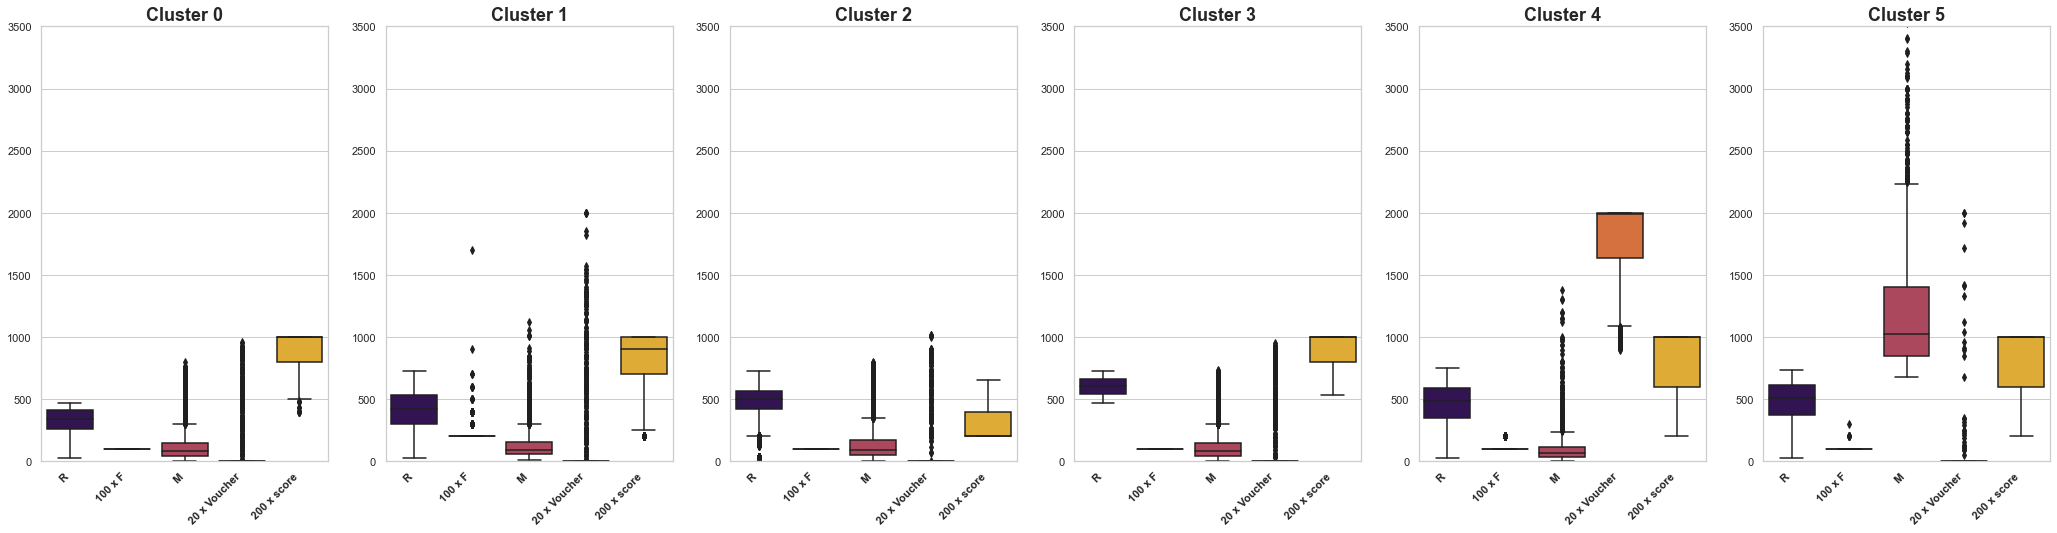

In [34]:
fig, ax = plt.subplots(1, 6, figsize=(36, 8))
for i in range(6):
    data_plot0 = data_stat0.loc[data_stat0['label']==i, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
    data_plot0['F'] = data_plot0['F'] * 100
    data_plot0['review_score_mean'] = data_plot0['review_score_mean'] * 200
    data_plot0['voucher'] = data_plot0['voucher'] * 20
    sns.boxplot(ax= ax[i], data=data_plot0, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '100 x F', 'M', '20 x Voucher', '200 x score'], weight='bold', rotation=45, ha='right', va='top')
    ax[i].set_ylim(0, 3500)
    fig.savefig('boxplot_par_cluster.pdf')

## Statistiques par cluster

#### <font color='purple'>_Fonction distribution_plot_</font>

In [35]:
def distribution_plot(data, title):
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    sns.histplot(ax=ax[1], data=data.iloc[:, 1], discrete=True, binrange=(0, 5), stat='percent')
    ax[1].set_ylabel('')
    ax[1].set_xlabel(data.columns[1], weight='bold')
    sns.histplot(ax=ax[0], data=data.iloc[:, 0], binwidth=40, binrange=(0, 800))
    ax[0].set_ylabel(f"{title}", fontsize=18, weight='bold')
    ax[0].set_xlabel(data.columns[0], weight='bold')
    sns.histplot(ax=ax[2], data=np.log(1+data.iloc[:, 2]), binwidth=0.5, binrange=(0, 10))
    ax[2].set_ylabel('')
    ax[2].set_xlabel(f"Log( 1 + {data.columns[2]})", weight='bold')
    sns.histplot(ax=ax[3], data=data.iloc[:, 3], stat='percent', binwidth=5, binrange=(0, 100))
    ax[3].set_ylabel('')
    ax[3].set_xlabel(data.columns[3], weight='bold')
    sns.histplot(ax=ax[4], data=data.iloc[:, 4], discrete=True, binrange=(0, 5))
    ax[4].set_ylabel('')
    ax[4].set_xlabel('Review score', weight='bold')
    #fig.suptitle(f"{title}", fontsize=18, weight='bold')
    fig.savefig(f"{title}.pdf")

#### <font color='purple'>_Fonction silhouette_per_cluster_</font>

In [159]:
def silhouette_per_cluster(data, labels, cluster, sample_size):
    """
    A partir d'un échantillon de taille sample_size de data :
    Renvoie le coefficient de silhouette moyen des individus appartenant au cluster cluster
    """
    data_sample = pd.DataFrame(data).sample(n=sample_size, replace=False)
    index = data_sample.index
    silhouette = silhouette_samples(data_sample, labels[index])
    mask = labels[index]==cluster
    silhouette_cluster = silhouette[mask].mean()
    return silhouette_cluster

#### <font color='purple'>_Fonction homogeneity_per_cluster_</font>

In [216]:
def homogeneity_per_cluster_(data_transformed, clusters, cluster):
    mask = data_transformed[clusters]==cluster
    data_cluster = data_transformed[mask]
    cluster_size = len(data_cluster)
    homogeneity = data_cluster[cluster].sum()/cluster_size
    return homogeneity

In [217]:
homogeneity_per_cluster_(X_transformed, 'clusters', 5)

2.6627070142312452

### Cluster 3

In [36]:
cluster3 = data_stat0.loc[data_stat0['label']==3, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
cluster3.describe()

,R,F,M,voucher,review_score_mean
count,40952.000000,40952.0,40952.000000,40952.000000,40952.000000
mean,601.947500,1.0,114.836424,0.148091,4.668612
std,72.558578,0.0,106.951182,2.218754,0.563243
min,466.000000,1.0,0.000000,0.000000,2.660179
25%,540.000000,1.0,44.990000,0.000000,4.000000
50%,605.000000,1.0,84.890000,0.000000,5.000000
75%,665.000000,1.0,146.010000,0.000000,5.000000
max,729.000000,1.0,735.000000,47.801147,5.000000


In [176]:
silhouette_per_cluster(X_scaled0, clusters0, 3, 30000)

0.4658795814207013

In [37]:
begining + pd.to_timedelta(cluster3['R'].min(), unit='D')

datetime.date(2017, 12, 14)

In [38]:
cluster3.quantile(q=0.9985)

R                    722.000000
F                      1.000000
M                    679.000000
voucher               37.445444
review_score_mean      5.000000
Name: 0.9985, dtype: float64

In [39]:
cluster3.quantile(q=0.994)

R                    719.00000
F                      1.00000
M                    599.71764
voucher                0.00000
review_score_mean      5.00000
Name: 0.994, dtype: float64

In [40]:
# Le groupe des clients récents avec une seule commande - Groupe le plus nombreux
# commandes postérieures au 14 décembre 2017
# une seule commande
# d'un montant inférieur à 680 euros (à l'exeption de moins de 0.15% qui ont fait une commande entre 680 et 735)
# pas de voucher (à l'exeption de moins de 0.6% des clients qui utilise un voucher de moins de 48% du payment value)
# review score minimum : 3

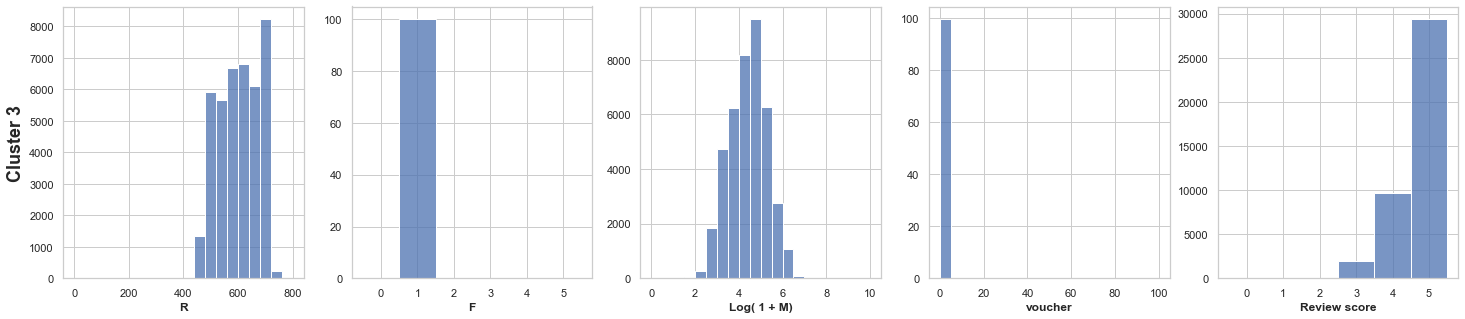

In [41]:
distribution_plot(cluster3, 'Cluster 3')

### cluster 0

In [42]:
cluster0 = data_stat0.loc[data_stat0['label']==0, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
cluster0.describe()

,R,F,M,voucher,review_score_mean
count,30755.000000,30755.0,30755.000000,30755.000000,30755.000000
mean,330.716794,1.0,117.706791,0.179621,4.627577
std,95.444708,0.0,113.047802,2.400508,0.599457
min,29.000000,1.0,2.290000,0.000000,2.000000
25%,258.000000,1.0,45.900000,0.000000,4.000000
50%,341.000000,1.0,84.000000,0.000000,5.000000
75%,415.000000,1.0,147.900000,0.000000,5.000000
max,470.000000,1.0,799.000000,47.971776,5.000000


In [177]:
silhouette_per_cluster(X_scaled0, clusters0, 0, 30000)

0.3770036070616196

In [43]:
begining + pd.to_timedelta(cluster0['R'].max(), unit='D')

datetime.date(2017, 12, 18)

In [44]:
cluster0.quantile(q=0.997)

R                    466.000000
F                      1.000000
M                    679.863320
voucher               29.380963
review_score_mean      5.000000
Name: 0.997, dtype: float64

In [45]:
cluster0.quantile(q=0.993)

R                    465.00000
F                      1.00000
M                    619.95888
voucher                0.00000
review_score_mean      5.00000
Name: 0.993, dtype: float64

In [46]:
cluster0.quantile(q=0.0003)

R                    30.000000
F                     1.000000
M                     5.590480
voucher               0.000000
review_score_mean     2.234981
Name: 0.0003, dtype: float64

In [47]:
# Le groupe des clients ancien avec une seule commande - Groupe le deuxième plus nombreux
# commandes antérieures au 18 décembre 2017 (commandes anciennes)
# une seule commande
# d'un montant inférieur à 680 euros (à l'exception de moins de 0.3% qui ont fait une commande entre 680 et 799)
# pas de voucher (à l'exeption de moins de 0.7% des clients qui utilise un voucher de moins de 48% du payment value)
# review score minimum : 3 (à l'exeption de moins de 0.03% des clients qui ont mis un score moyen de 2)

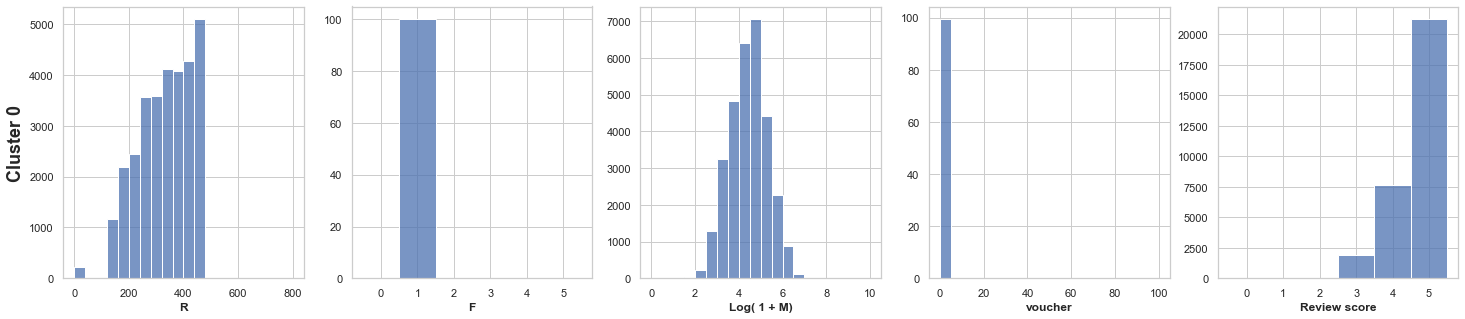

In [48]:
distribution_plot(cluster0, 'Cluster 0')

### cluster 2

In [49]:
cluster2 = data_stat0.loc[data_stat0['label']==2, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
cluster2.describe()

,R,F,M,voucher,review_score_mean
count,1.650800e+04,16508.0,16508.000000,16508.000000,16508.000000
mean,4.808367e+02,1.0,135.425789,0.194286,1.604644
std,1.327331e+02,0.0,129.395918,2.526114,0.814868
min,5.684342e-14,1.0,0.000000,0.000000,1.000000
25%,4.190000e+02,1.0,49.900000,0.000000,1.000000
50%,5.000000e+02,1.0,95.000000,0.000000,1.000000
75%,5.630000e+02,1.0,169.900000,0.000000,2.000000
max,7.240000e+02,1.0,798.000000,50.830747,3.285606


In [178]:
silhouette_per_cluster(X_scaled0, clusters0, 2, 30000)

0.35978431316298626

In [50]:
cluster2.quantile(q=0.993)

R                    7.120000e+02
F                    1.000000e+00
M                    6.767216e+02
voucher              4.005685e-16
review_score_mean    3.000000e+00
Name: 0.993, dtype: float64

In [51]:
cluster2.quantile(q=0.992)

R                    711.00000
F                      1.00000
M                    659.97936
voucher                0.00000
review_score_mean      3.00000
Name: 0.992, dtype: float64

In [52]:
# une seule commande
# d'un montant inférieur à 680 euros (à l'exeption de moins de 0.7% qui ont fait une commande entre 680 et 798)
# pas de voucher (à l'exeption de moins de 0.8% des clients qui utilise un voucher de moins de 51% du payment value)
# review score maxi : 3

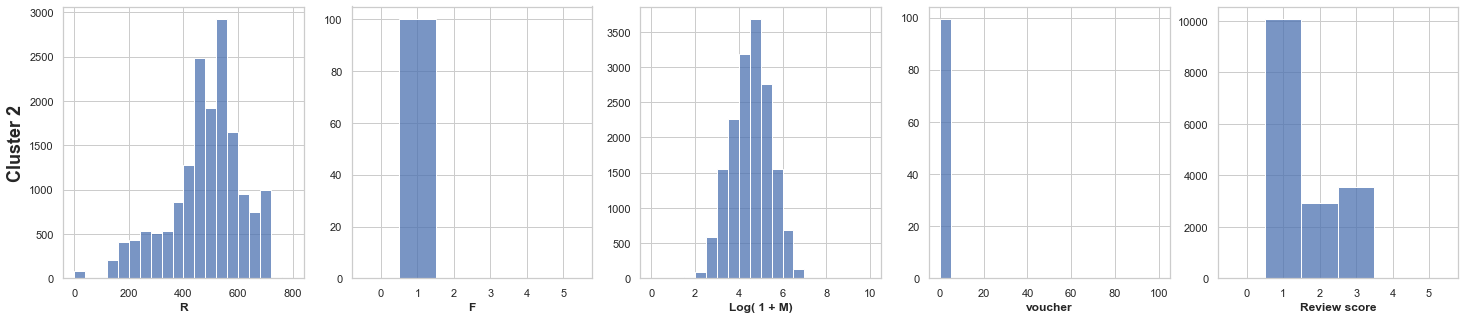

In [53]:
distribution_plot(cluster2, 'Cluster 2')

### cluster 4

In [54]:
cluster4 = data_stat0.loc[data_stat0['label']==4, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
cluster4.describe()

,R,F,M,voucher,review_score_mean
count,2969.000000,2969.000000,2969.000000,2969.000000,2969.000000
mean,467.567531,1.019872,98.082164,89.434238,4.034084
std,155.754332,0.139584,120.932290,14.924596,1.364165
min,30.000000,1.000000,2.200000,44.916647,1.000000
25%,345.000000,1.000000,35.270000,81.718088,3.000000
50%,482.000000,1.000000,65.000000,99.490347,5.000000
75%,593.000000,1.000000,117.300000,100.000000,5.000000
max,755.000000,2.000000,1375.000000,100.000000,5.000000


In [179]:
silhouette_per_cluster(X_scaled0, clusters0, 4, 30000)

0.5544395932487125

In [55]:
cluster4.quantile(q=0.98)

R                    710.00
F                      1.00
M                    433.19
voucher              100.00
review_score_mean      5.00
Name: 0.98, dtype: float64

In [56]:
cluster4.quantile(q=0.52)

R                    493.0
F                      1.0
M                     69.0
voucher              100.0
review_score_mean      5.0
Name: 0.52, dtype: float64

In [57]:
# Le groupe des clients utilisateurs de vouchers
# maxi 2 commandes (en fait plus de 98% des clients n'ont fait qu'une commande)
# voucher mini 45% (et presque 50% des clients ont payé la totalité en voucher)

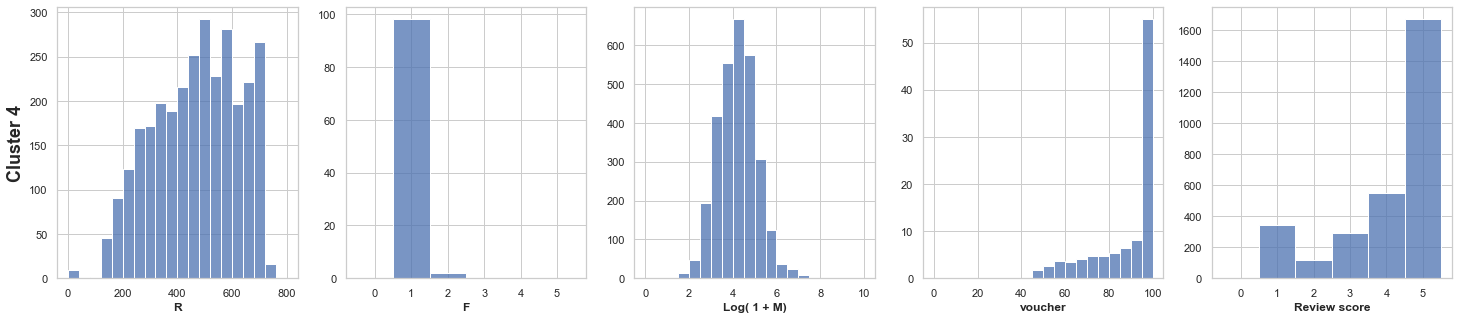

In [58]:
distribution_plot(cluster4, 'Cluster 4')

### cluster 1

In [59]:
cluster1 = data_stat0.loc[data_stat0['label']==1, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
cluster1.describe()

,R,F,M,voucher,review_score_mean
count,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,417.095287,2.118511,128.284228,2.988281,4.109824
std,148.063134,0.522103,122.417574,12.231203,1.138484
min,29.000000,2.000000,6.900000,0.000000,1.000000
25%,300.000000,2.000000,56.436250,0.000000,3.500000
50%,423.000000,2.000000,92.422500,0.000000,4.500000
75%,534.000000,2.000000,152.492500,0.000000,5.000000
max,724.000000,17.000000,1119.210000,100.000000,5.000000


In [180]:
silhouette_per_cluster(X_scaled0, clusters0, 1, 30000)

0.501622956758811

In [60]:
# le groupe des clients ayant fait plusieurs achats
# deux commandes et plus
# montant inférieur à 1120 euros

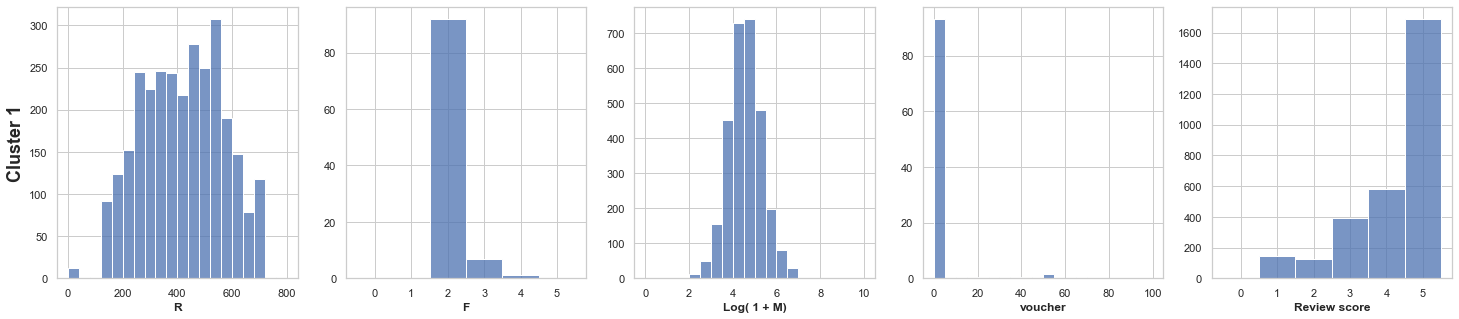

In [61]:
distribution_plot(cluster1, 'Cluster 1')

### cluster 5

In [62]:
cluster5 = data_stat0.loc[data_stat0['label']==5, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
cluster5.describe()

,R,F,M,voucher,review_score_mean
count,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000
mean,486.334846,1.005547,1259.671506,0.543334,3.889549
std,154.506897,0.080798,714.097405,5.837350,1.498687
min,30.000000,1.000000,679.000000,0.000000,1.000000
25%,372.000000,1.000000,845.000000,0.000000,3.000000
50%,507.000000,1.000000,1023.000000,0.000000,5.000000
75%,615.000000,1.000000,1404.550000,0.000000,5.000000
max,732.000000,3.000000,13440.000000,100.000000,5.000000


In [181]:
silhouette_per_cluster(X_scaled0, clusters0, 5, 30000)

0.24995868644651445

In [63]:
cluster5.quantile(q=0.994)

R                     715.00000
F                       1.00000
M                    4414.97704
voucher                42.63719
review_score_mean       5.00000
Name: 0.994, dtype: float64

In [64]:
cluster5.quantile(q=0.984)

R                     710.288
F                       1.000
M                    3443.272
voucher                 0.000
review_score_mean       5.000
Name: 0.984, dtype: float64

In [65]:
cluster5.quantile(q=0.3)

R                    401.60
F                      1.00
M                    869.79
voucher                0.00
review_score_mean      4.00
Name: 0.3, dtype: float64

In [66]:
cluster5.quantile(q=0.98)

R                     709.000
F                       1.000
M                    3101.736
voucher                 0.000
review_score_mean       5.000
Name: 0.98, dtype: float64

In [67]:
# Le groupe des clients ayant fait un gros achat - Groupe comportant le moins d'individus
# 1 commande (pour être précise : moins de 0.6% des clients ont fait 2 ou 3 commandes. Les autres ont fait une seule commande)
# montant mini 680 (84% au delà de 800 et 42% au delà de 1120)
# moins de 2% des clients de ce groupe ont utilisé un voucher

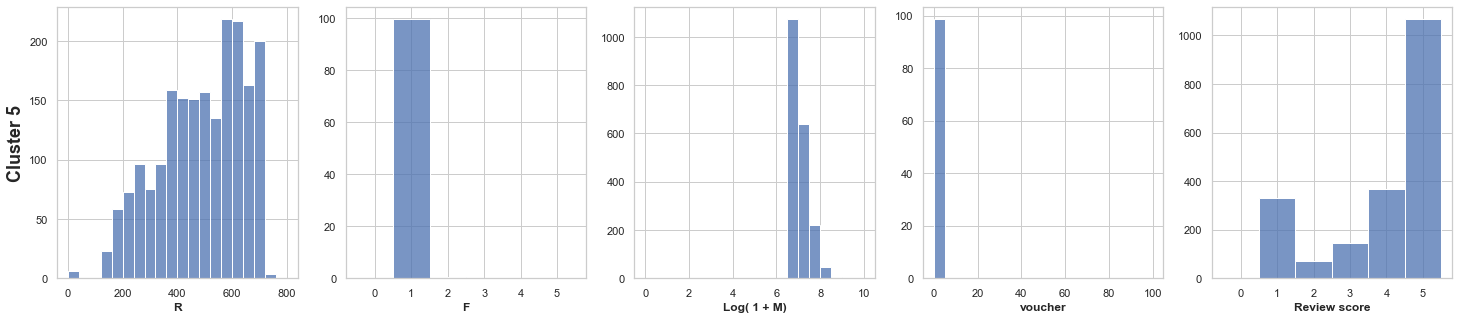

In [68]:
distribution_plot(cluster5, 'Cluster 5')

# Rand Score différents délais
## 180 jours

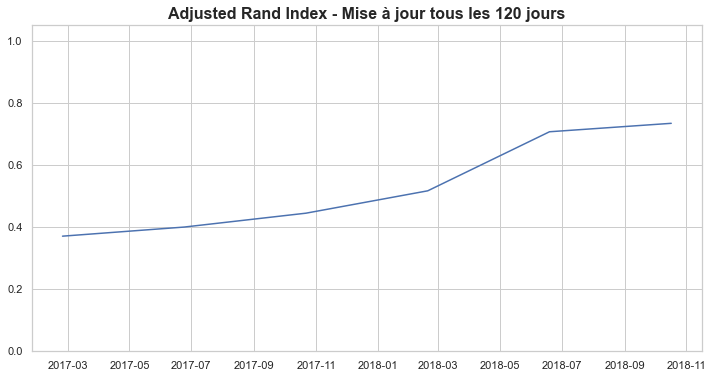

In [50]:
adjusted_rand(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 120, 6)

## 90 jours

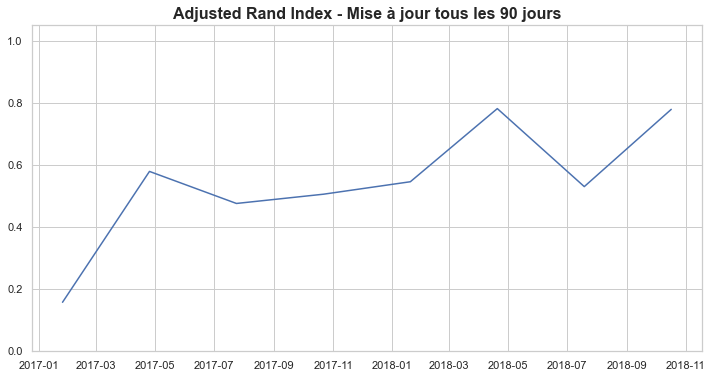

In [51]:
adjusted_rand(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 90, 7)

## 60 jours

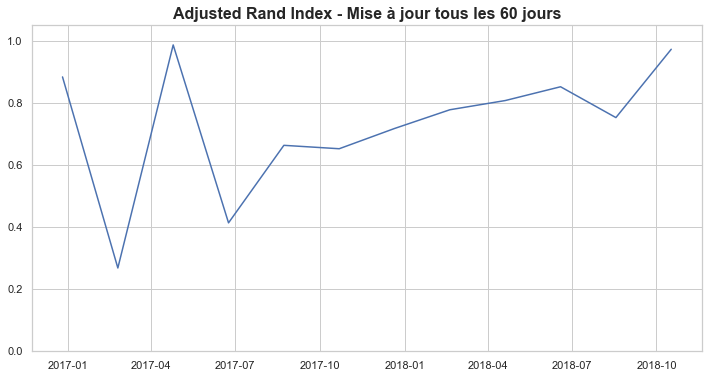

In [52]:
adjusted_rand(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 60, 6)

## 30 jours

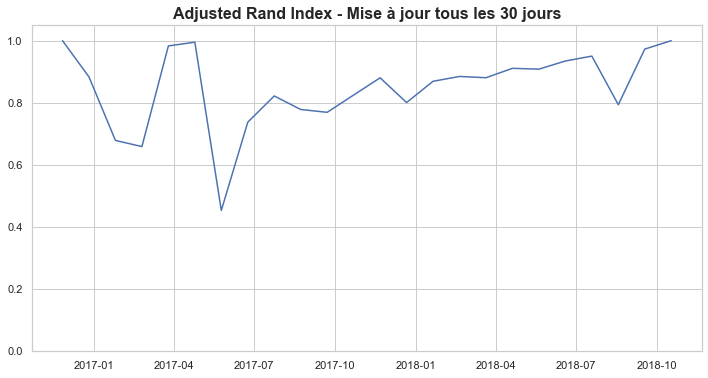

In [54]:
adjusted_rand(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 30, 6)

## 15 jours

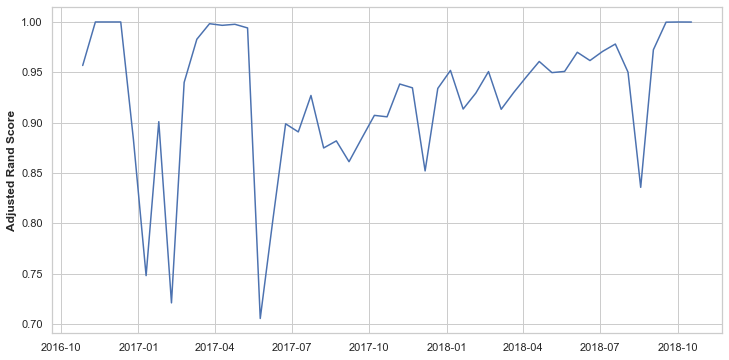

In [88]:
adjusted_rand(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 15, 6)

## 7 jours

In [ ]:
adjusted_rand(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 7, 6)

## 2 jours

In [ ]:
adjusted_rand(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 2, 6)

In [ ]:
# Pour conserver un ajusted rand index supérieur à 0.8, une mise à jour tous les mois est nécessaire.
# Il faut mettre à jour le clustering tous les 2 jours pour rester au delà de 0.9 et tous les 60 jours pour 0.75.

# Silhouette Score différents délais
## 120 jours

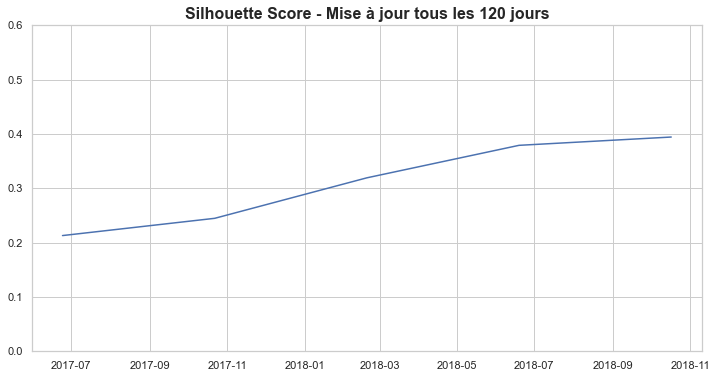

In [61]:
silhouette_evolve(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 120, 6, 10000)

## 90 jours

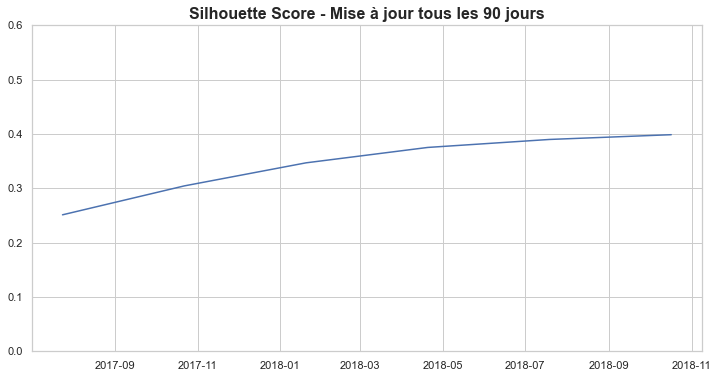

In [62]:
silhouette_evolve(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 90, 7, 10000)

## 60 jours

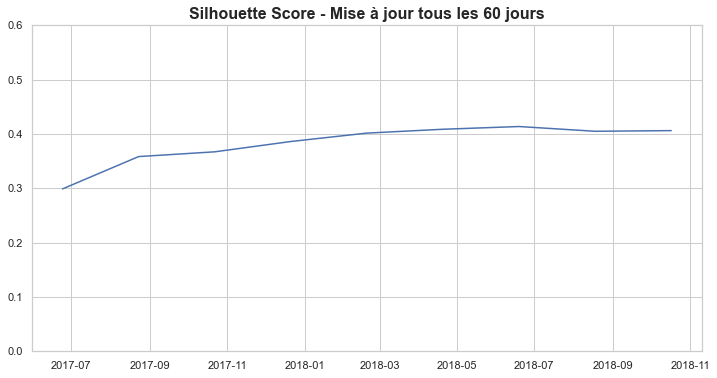

In [63]:
silhouette_evolve(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 60, 6, 10000)

## 30 jours

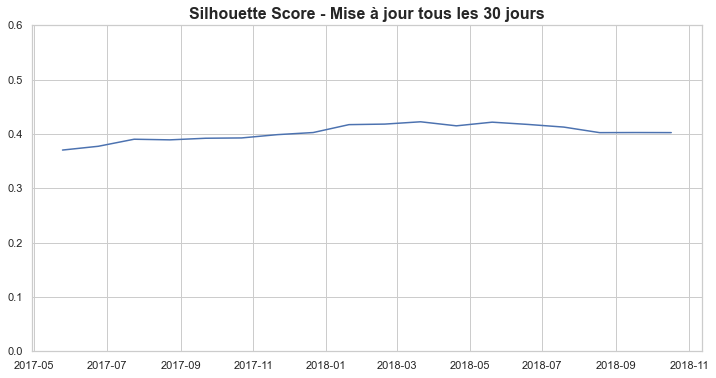

In [64]:
silhouette_evolve(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 30, 6, 10000)

## 15 jours

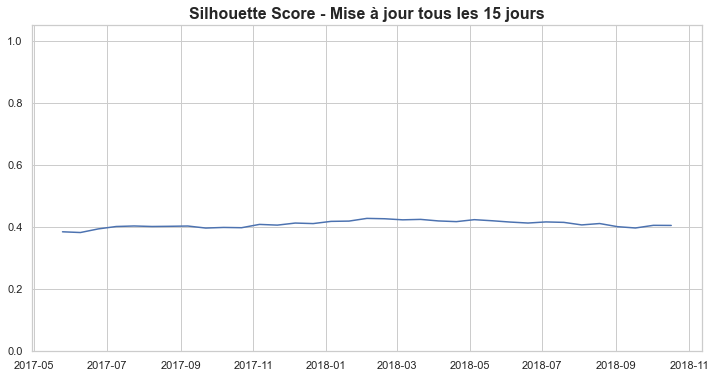

In [59]:
silhouette_evolve(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 15, 6, 10000)

## 7 jours

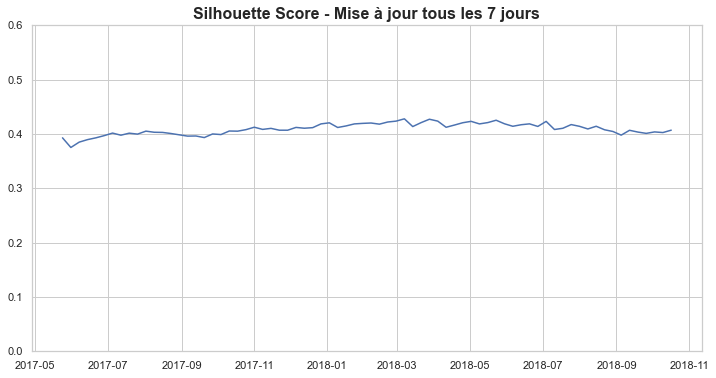

In [65]:
silhouette_evolve(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 7, 6, 10000)

## 2 jours

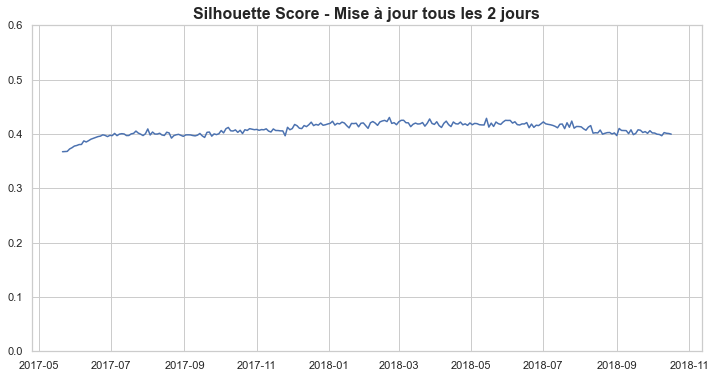

In [66]:
silhouette_evolve(data, 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 2, 6, 10000)

# Evolution des clusters

#### <font color='purple'>_Fonction compare_clusters_</font>

In [117]:
def compare_clusters(data, date1, date2, col_date, col_agg, dict_agg, col1, col2, nb_clust, col_condition, value, condition=True):
    """
    Compare les clusters entrainés à date1 et date2 pour les individus où col_condition vérifie col_condition > value
    Pour modifier condition en col_condition =< value, choisir condition=False
    """
    # clustering pour date 1
    data_date1 = data_date_id(data, col_date, col_agg, date1, dict_agg, )
    data_date10 = ratio(data_date1, col1, col2)
    data_date100 = data_date10.drop(col_agg, axis=1)
    X_scaled1 = StandardScaler().fit_transform(data_date100)
    km1 = KMeans(n_clusters= n_clust, random_state=0)
    km1.fit(X_scaled1)
    clusters1 = km1.labels_
    # clustering pour date 2
    data_date2 = data_date_id(data, col_date, col_agg, date2, dict_agg)
    data_date20 = ratio(data_date2, col1, col2)
    data_date200 = data_date20.drop(col_agg, axis=1)
    X_scaled2 = StandardScaler().fit_transform(data_date200)
    km2 = KMeans(n_clusters= n_clust, random_state=0)
    km2.fit(X_scaled2)
    clusters2 = km2.labels_
    
    data_stat1 = data_date10.copy()
    data_stat1['label1'] = clusters1
    data_stat2 = data_date2.copy()
    data_stat2['label2'] = clusters2
    if condition:
        mask1 = data_stat1[col_condition]>value
    else:
        mask1 = data_stat1[col_condition]<value
    customers_multi1 = data_stat1[mask1]
    if condition:
        mask2 = data_stat2[col_condition]>value
    else:
        mask2 = data_stat2[col_condition]<value
    customers_multi2 = data_stat2[mask2]
    compare_cust_multi = pd.merge(customers_multi1.loc[:, [col_agg,'label1']], 
                                  customers_multi2.loc[:, [col_agg,'label2']], 
                                  left_on=col_agg, 
                                  right_on=col_agg, 
                                  how='inner'
                                 )
    sizes = {} 
    for (yt, yp) in zip(compare_cust_multi['label1'],
                    compare_cust_multi['label2']):
        if (yt, yp) in sizes:
            sizes[(yt, yp)] += 0.1
        else:
            sizes[(yt, yp)] = 0.1
    return sizes

## Clients plusieurs commandes

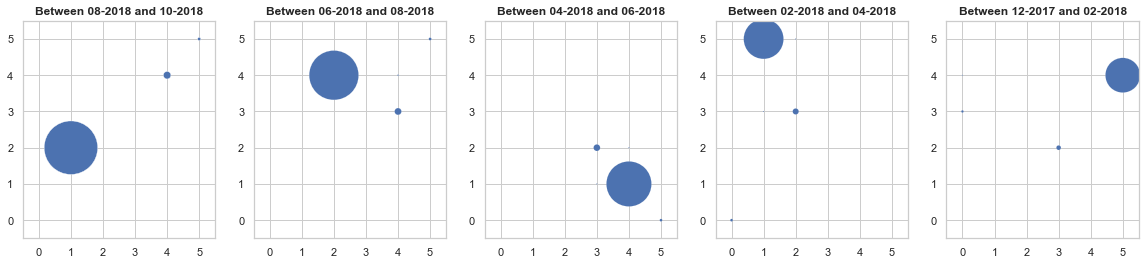

In [118]:
# Evolution des clusters pour les clients multiples 60 jours
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
dates = []
end_date = pd.to_datetime(data['date_of_purchase'].max()).date()
for j in range(6):
    dates += [end_date - pd.to_timedelta(60*j, unit='D')]
for i in range(len(dates)-1):
    sizes = compare_clusters(data, dates[i], dates[i+1], 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 6, 'F', 1)
    key = sizes.keys()
    sns.scatterplot(ax=ax[i], data=key,
        x=[k[0] for k in key],
        y=[k[1] for k in key],
        s=[10*sizes[k] for k in key])
    ax[i].set(xlim=(-0.5, 5.5), ylim=(-0.5, 5.5))
    ax[i].set_title(label=f"Between {dates[i+1].strftime('%m-%Y')} and {dates[i].strftime('%m-%Y')}", weight='bold') 
    ax[i].set(xticks=np.arange(0,6,1))

In [93]:
fig.savefig('compare_multi_60j.pdf')

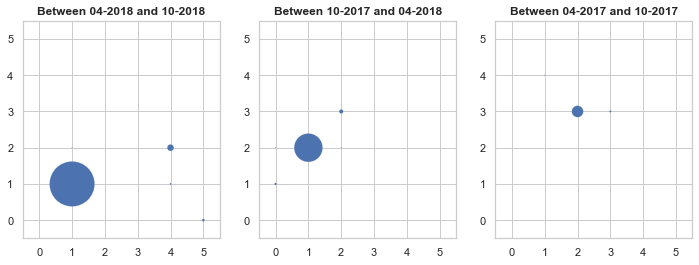

In [120]:
# Evolution des clusters pour les clients multiples 180 jours
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
dates = []
end_date = pd.to_datetime(data['date_of_purchase'].max()).date()
for j in range(4):
    dates += [end_date - pd.to_timedelta(180*j, unit='D')]
for i in range(len(dates)-1):
    sizes = compare_clusters(data, dates[i], dates[i+1], 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 6, 'F', 1)
    key = sizes.keys()
    sns.scatterplot(ax=ax[i], data=key,
        x=[k[0] for k in key],
        y=[k[1] for k in key],
        s=[10*sizes[k] for k in key])
    ax[i].set(xlim=(-0.5, 5.5), ylim=(-0.5, 5.5))
    ax[i].set_title(label=f"Between {dates[i+1].strftime('%m-%Y')} and {dates[i].strftime('%m-%Y')}", weight='bold')
    ax[i].set(xticks=np.arange(0,6,1))

In [112]:
fig.savefig('compare_multi_180j.pdf')

## Clients gros montants

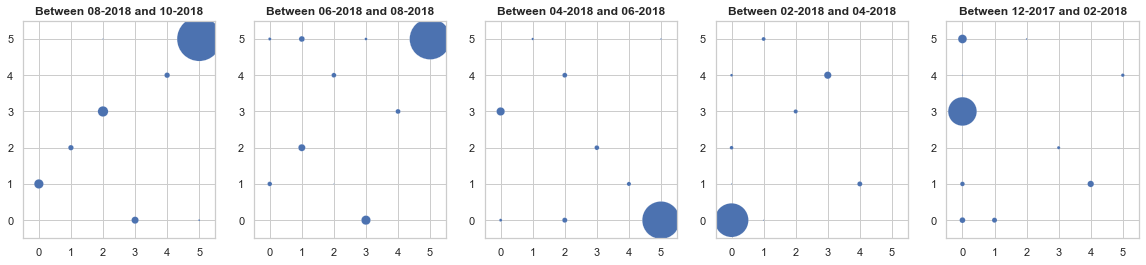

In [333]:
# Evolution des clusters pour les clients faisant des commandes importantes - 60 jours
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
dates = []
for j in range(6):
    dates += [end - pd.to_timedelta(60*j, unit='D')]
for i in range(len(dates)-1):
    sizes = compare_clusters(data, dates[i], dates[i+1], 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 6, 'M', 680)
    key = sizes.keys()
    sns.scatterplot(ax=ax[i], data=key,
        x=[k[0] for k in key],
        y=[k[1] for k in key],
        s=[10*sizes[k] for k in key])
    ax[i].set(xlim=(-0.5, 5.5), ylim=(-0.5, 5.5))
    ax[i].set_title(label=f"Between {dates[i+1].strftime('%m-%Y')} and {dates[i].strftime('%m-%Y')}", weight='bold') 
    ax[i].set(xticks=np.arange(0,6,1))
fig.savefig('compare_M_60j.pdf')

## Clients avec vouchers

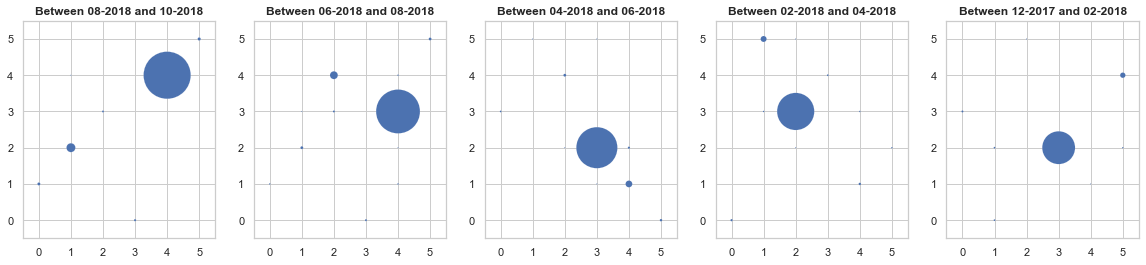

In [122]:
# Evolution des clusters pour les clients utilisant des vouchers - 60 jours
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
dates = []
for j in range(6):
    dates += [end - pd.to_timedelta(60*j, unit='D')]
for i in range(len(dates)-1):
    sizes = compare_clusters(data, dates[i], dates[i+1], 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 6, 'voucher', 45)
    key = sizes.keys()
    sns.scatterplot(ax=ax[i], data=key,
        x=[k[0] for k in key],
        y=[k[1] for k in key],
        s=[10*sizes[k] for k in key])
    ax[i].set(xlim=(-0.5, 5.5), ylim=(-0.5, 5.5))
    ax[i].set_title(label=f"Between {dates[i+1].strftime('%m-%Y')} and {dates[i].strftime('%m-%Y')}", weight='bold') 
    ax[i].set(xticks=np.arange(0,6,1))

## Clients mécontents

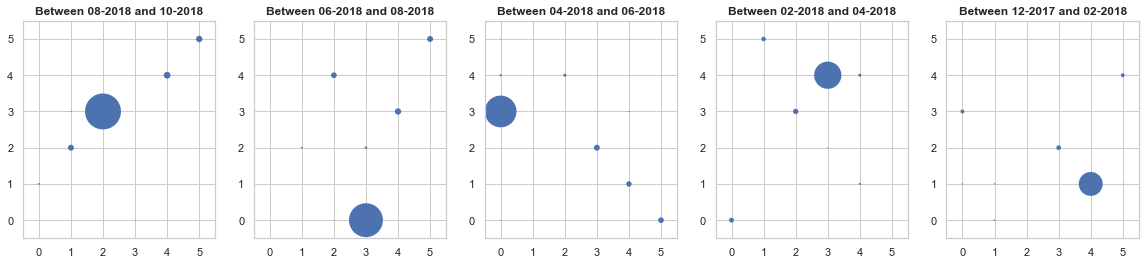

In [123]:
# Evolution des clusters pour les clients attribuant un score inférieur ou égal à 3
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
dates = []
for j in range(6):
    dates += [end - pd.to_timedelta(60*j, unit='D')]
for i in range(len(dates)-1):
    sizes = compare_clusters(data, dates[i], dates[i+1], 'date_of_purchase', 'customer_unique_id', aggregation, 'voucher', 'payment_value', 6, 'review_score_mean', 3, condition=False)
    key = sizes.keys()
    sns.scatterplot(ax=ax[i], data=key,
        x=[k[0] for k in key],
        y=[k[1] for k in key],
        s=[sizes[k] for k in key])
    ax[i].set(xlim=(-0.5, 5.5), ylim=(-0.5, 5.5))
    ax[i].set_title(label=f"Between {dates[i+1].strftime('%m-%Y')} and {dates[i].strftime('%m-%Y')}", weight='bold') 
    ax[i].set(xticks=np.arange(0,6,1))